### 模型评估

In [17]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import LoraConfig, PeftModel, TaskType
import torch

# 加载分词器
tokenizer = AutoTokenizer.from_pretrained("./Qwen2.5-0.5B-Instruct", use_fast=False, trust_remote_code=True)
# 加载基础模型
model = AutoModelForCausalLM.from_pretrained("./Qwen2.5-0.5B-Instruct", device_map="cuda", torch_dtype="auto")

# 加载 LoRA 适配器权重
model = PeftModel.from_pretrained(
    model,
    model_id="./output/multi-class-20epoch/checkpoint-7500/",
)
# 合并权重 （！！！加了这行会出现乱码）
model = model.merge_and_unload()

In [18]:
test_df = pd.read_json('eval-400x10.json')

def predict(messages, model, tokenizer):
    device = "cuda"
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(device)
    input_ids = tokenizer.encode(text,return_tensors='pt')
    attention_mask = torch.ones(input_ids.shape,dtype=torch.long,device=device)

    generated_ids = model.generate(
        model_inputs.input_ids,
        max_new_tokens=512,
        pad_token_id=tokenizer.eos_token_id,
        attention_mask=attention_mask
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    # print(response)
    return response


In [19]:
# 定义短信风险类别选项
categories = [
    "无风险",
    "冒充电商物流客服类",
    "虚假网络投资理财类",
    "虚假信用服务类",
    "虚假购物、服务类",
    "冒充公检法及政府机关类",
    "冒充领导、熟人类",
    "网络婚恋、交友类",
    "冒充军警购物类诈骗",
    "网黑案件"
]

# 生成类别对应索引的字典
category2index = {category: index for index, category in enumerate(categories)}

# 打印字典
print(category2index)

{'无风险': 0, '冒充电商物流客服类': 1, '虚假网络投资理财类': 2, '虚假信用服务类': 3, '虚假购物、服务类': 4, '冒充公检法及政府机关类': 5, '冒充领导、熟人类': 6, '网络婚恋、交友类': 7, '冒充军警购物类诈骗': 8, '网黑案件': 9}


In [20]:
from tqdm import tqdm
category = "短信风险类别选项有：无风险|冒充电商物流客服类|虚假网络投资理财类|虚假信用服务类|虚假购物、服务类|冒充公检法及政府机关类|冒充领导、熟人类|网络婚恋、交友类|冒充军警购物类诈骗|网黑案件"
prompt = '''在这个任务中，你是一位资深的反诈骗网络安全分析师，你的职责是利用你的专业知识和对网络诈骗行为的深刻理解，从短信文本中识别出可能存在的欺诈行为和风险类别。你的工作对于提前预警潜在的网络诈骗，保护用户财产安全和个人信息不被侵犯具有重要意义。现在，请仔细审查以下短信文本，并运用你的专业判断，给出短信的风险类别判断结果。(%s)'''%category

y_true = []  # 真实标签
y_pred = []  # 预测标签
correct = 0
for index, row in tqdm(test_df.iterrows(), total=len(test_df)):
    input_value = row['文本']
    messages = [
        {"role": "system", "content": f"{prompt}"},
        {"role": "user", "content": f"{input_value}"}
    ]
    response = predict(messages, model, tokenizer).strip()
    answer = row['风险类别']
    if response in categories:
        y_pred.append(category2index[response])
        y_true.append(category2index[answer])
    if response == answer:
        correct += 1
    # else:
    #     print(response, answer)

accuracy = correct / test_df.shape[0]
print(correct, test_df.shape[0])
print("accuracy: ", accuracy)


100%|██████████| 4000/4000 [27:32<00:00,  2.42it/s]  

2853 4000
accuracy:  0.71325


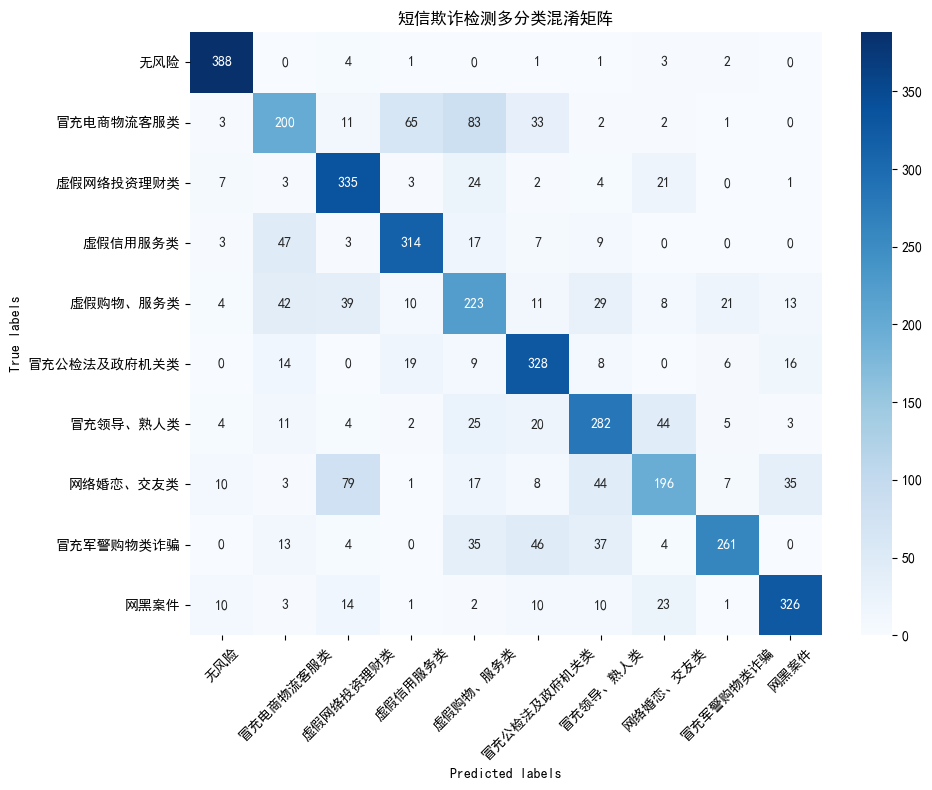

Precision: 0.7150
Recall: 0.7133
F1 Score: 0.7096


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
from matplotlib import rcParams

# 设置全局字体
rcParams['font.family'] = 'SimHei'  # 指定默认字体为黑体
rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)

# 绘制混淆矩阵热图
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('短信欺诈检测多分类混淆矩阵')
plt.xticks(rotation=45)  # 如果需要，可以旋转x轴标签以防止重叠
plt.yticks(rotation=0)
plt.tight_layout()  # 调整布局以适应标签
plt.show()

# 计算精确率、召回率和F1分数
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [22]:
# 计算精确率、召回率和F1分数
precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')
f1 = f1_score(y_true, y_pred, average='micro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.7133
Recall: 0.7133
F1 Score: 0.7133


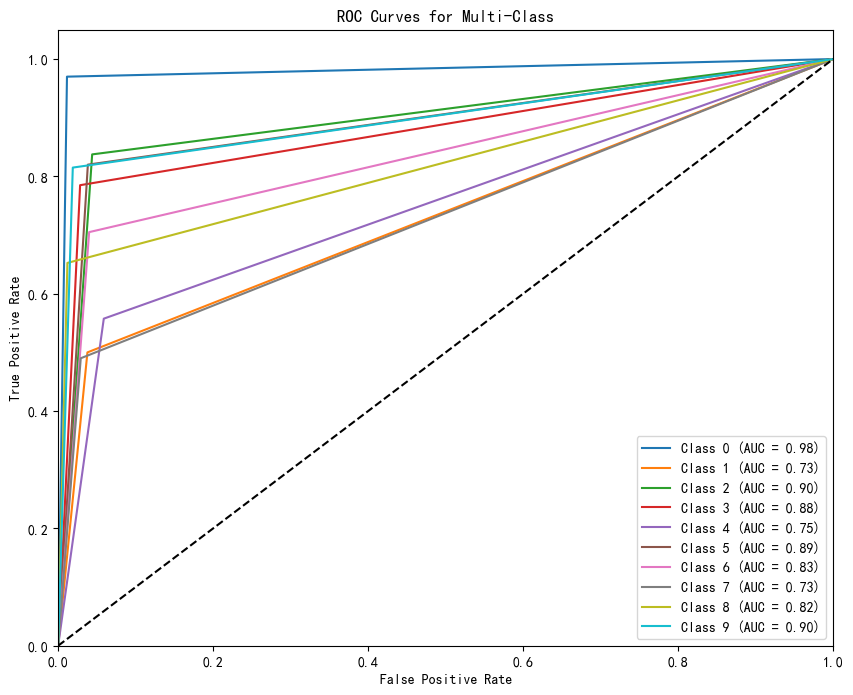

In [23]:
# 计算每个类别的ROC曲线和AUC值
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_pred == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制ROC曲线
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class')
plt.legend(loc="lower right")
plt.show()

In [26]:
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix

## 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)
cm

array([[388,   0,   4,   1,   0,   1,   1,   3,   2,   0],
       [  3, 200,  11,  65,  83,  33,   2,   2,   1,   0],
       [  7,   3, 335,   3,  24,   2,   4,  21,   0,   1],
       [  3,  47,   3, 314,  17,   7,   9,   0,   0,   0],
       [  4,  42,  39,  10, 223,  11,  29,   8,  21,  13],
       [  0,  14,   0,  19,   9, 328,   8,   0,   6,  16],
       [  4,  11,   4,   2,  25,  20, 282,  44,   5,   3],
       [ 10,   3,  79,   1,  17,   8,  44, 196,   7,  35],
       [  0,  13,   4,   0,  35,  46,  37,   4, 261,   0],
       [ 10,   3,  14,   1,   2,  10,  10,  23,   1, 326]], dtype=int64)